In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utilities import get_git_repo_path, log_bin

# Setup
git_path = get_git_repo_path()
all_temperatures = np.array([0.8, 1.0, 1.2, 1.5, 1.8, 2.2, 2.6, 3.0])
target_frequency = 150929  # MHz
ref_time = 463.7943 # LJ time in fs
ref_temp = 50.3219 # LJ temp in K

/home/simon/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Output containers
R1_at_target = []
R2_at_target = []
std_R1_at_target = []
std_R2_at_target = []
Gij_in_zero = []
std_Gij_in_zero = []
correlation_functions = []

# Read data
for T in all_temperatures:

    R1_at_target_T = []
    R2_at_target_T = []
    Gij_in_zero_T = []

    R1_spectra = []
    R2_spectra = []
    Gij_T = []

    for n in np.arange(1, 11):

        result_file = f"T{T}/result{n}.npy"
        
        if not os.path.exists(result_file):
            print(f"Warning: Missing result file for T={T}")
            continue

        data = np.load(result_file, allow_pickle=True).item()
        
        time_vector = np.real(data["t"])
        freq_vector = np.real(data["f"])
        idx_closest = np.argmin(np.abs(freq_vector - target_frequency))

        correlation_functions.append(data["C"])

        _, R1_spectra_log = log_bin(freq_vector[1:], data["R1"][1:], num_bins = 200)
        freq_vector_log, R2_spectra_log = log_bin(freq_vector[1:], data["R2"][1:], num_bins = 200)
        time_vector_log, correlation_function_log = log_bin(time_vector[1:], correlation_functions[-1][1:], num_bins = 200)

        np.savetxt(f"T{T}/R1_vs_f_n{n}.dat", np.vstack([freq_vector_log, R1_spectra_log]).T)
        np.savetxt(f"T{T}/R2_vs_f_n{n}.dat", np.vstack([freq_vector_log, R2_spectra_log]).T)
        np.savetxt(f"T{T}/Gij_vs_t_n{n}.dat", np.vstack([time_vector_log, correlation_function_log]).T)

        R1_spectra.append(R1_spectra_log)
        R2_spectra.append(R2_spectra_log)
        R1_at_target_T.append(data["R1"][idx_closest])
        R2_at_target_T.append(data["R2"][idx_closest])
        Gij_in_zero_T.append(data["C"][0])
        Gij_T.append(correlation_function_log)

    R1_at_target.append(np.mean(R1_at_target_T))
    R2_at_target.append(np.mean(R2_at_target_T))
    std_R1_at_target.append(np.std(R1_at_target_T)/np.sqrt(len(R1_at_target_T)))
    std_R2_at_target.append(np.std(R2_at_target_T)/np.sqrt(len(R2_at_target_T)))

    R1_spectra_log = np.mean(R1_spectra, axis=0)
    R2_spectra_log = np.mean(R2_spectra, axis=0)
    Gij_spectra_log = np.mean(Gij_T, axis=0)
    Gij_in_zero.append(np.mean(Gij_in_zero_T))

    std_Gij_in_zero.append(np.std(Gij_in_zero_T)/np.sqrt(len(Gij_in_zero_T)))

    np.savetxt(f"T{T}/R1_vs_f.dat", np.vstack([freq_vector_log, R1_spectra_log]).T)
    np.savetxt(f"T{T}/R2_vs_f.dat", np.vstack([freq_vector_log, R2_spectra_log]).T)
    np.savetxt(f"T{T}/Gi_vs_f.dat", np.vstack([time_vector_log, Gij_spectra_log]).T)

R1_at_target = np.array(R1_at_target)
R2_at_target = np.array(R2_at_target)
std_R1_at_target = np.array(std_R1_at_target)
std_R2_at_target = np.array(std_R2_at_target)
Gij_in_zero = np.array(Gij_in_zero)

np.savetxt("R1_at_target_vs_temperature.dat", np.vstack([all_temperatures, R1_at_target, std_R1_at_target]).T)
np.savetxt("R2_at_target_vs_temperature.dat", np.vstack([all_temperatures, R2_at_target, std_R2_at_target]).T)
np.savetxt("Gij_in_zero_vs_temperature.dat", np.vstack([all_temperatures, Gij_in_zero, std_Gij_in_zero]).T)

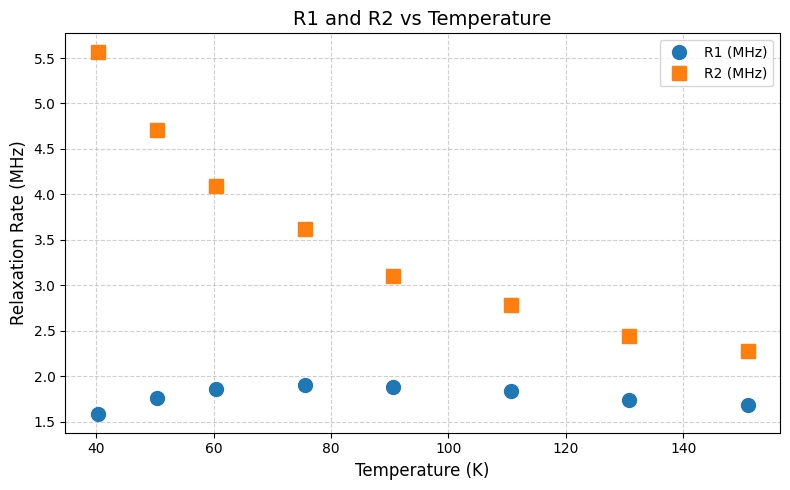

In [3]:
scaled_T = all_temperatures * ref_temp

plt.figure(figsize=(8, 5))
plt.errorbar(scaled_T, R1_at_target * 1000, std_R1_at_target * 1000, R1_at_target * 0, "o", label="R1 (MHz)", markersize = 10)
plt.errorbar(scaled_T, R2_at_target * 1000, std_R1_at_target * 1000, R2_at_target * 0, "s", label="R2 (MHz)", markersize = 10)

plt.xlabel("Temperature (K)", fontsize=12)
plt.ylabel("Relaxation Rate (MHz)", fontsize=12)
plt.title("R1 and R2 vs Temperature", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("R_at_target_vs_temperature.png", dpi=300)
plt.show()

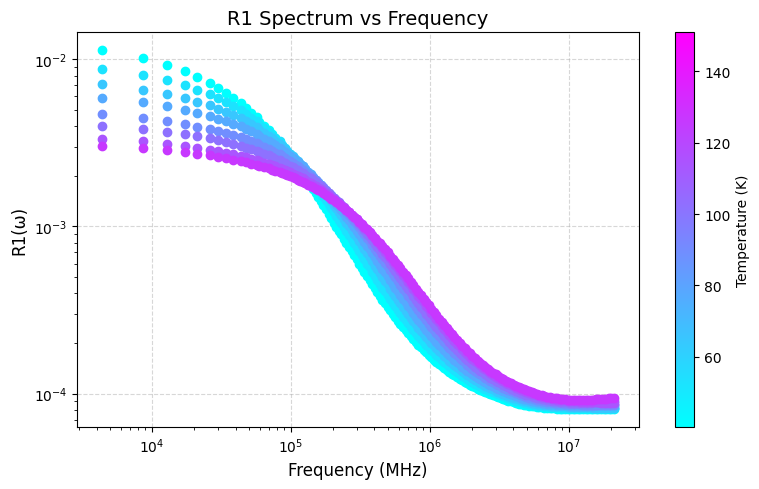

In [4]:
fig, ax = plt.subplots(figsize=(8, 5))

# Colormap and color assignment
cmap = plt.cm.cool
colors = cmap(np.linspace(0, 1, len(R1_spectra)))

# Plot each R1 spectrum
for i, (T, color) in enumerate(zip(all_temperatures, colors)):
    freq_vector_log, R1_spectra_log = np.loadtxt(f"T{T}/R1_vs_f.dat").T
    ax.loglog(freq_vector_log, R1_spectra_log, "o", label=f"T = {T*ref_temp:.1f} K", color=color)

# Axis labels and title
ax.set_xlabel("Frequency (MHz)", fontsize=12)
ax.set_ylabel("R1(ω)", fontsize=12)
ax.set_title("R1 Spectrum vs Frequency", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.5)

# Colorbar representing temperature gradient
norm = plt.Normalize(vmin=all_temperatures[0]*ref_temp, vmax=all_temperatures[-1]*ref_temp)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label="Temperature (K)")

plt.tight_layout()
plt.savefig("R1_spectrum.png", dpi=300)
plt.show()

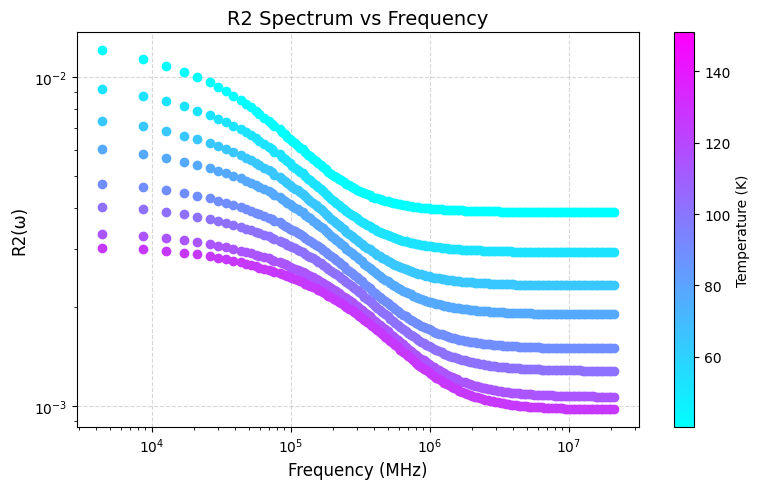

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))

# Colormap and color assignment
cmap = plt.cm.cool
colors = cmap(np.linspace(0, 1, len(R1_spectra)))

# Plot each R1 spectrum
for i, (T, color) in enumerate(zip(all_temperatures, colors)):
    freq_vector_log, R1_spectra_log = np.loadtxt(f"T{T}/R2_vs_f.dat").T
    ax.loglog(freq_vector_log, R1_spectra_log, "o", label=f"T = {T*ref_temp:.1f} K", color=color)

# Axis labels and title
ax.set_xlabel("Frequency (MHz)", fontsize=12)
ax.set_ylabel("R2(ω)", fontsize=12)
ax.set_title("R2 Spectrum vs Frequency", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.5)

# Colorbar representing temperature gradient
norm = plt.Normalize(vmin=all_temperatures[0]*ref_temp, vmax=all_temperatures[-1]*ref_temp)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label="Temperature (K)")

plt.tight_layout()
plt.savefig("R2_spectrum.png", dpi=300)
plt.show()

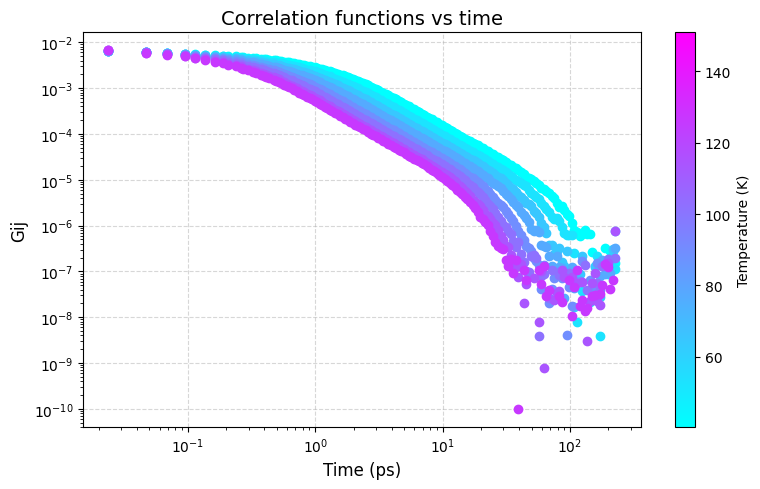

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))

# Colormap and color assignment
cmap = plt.cm.cool
colors = cmap(np.linspace(0, 1, len(R1_spectra)))

# Plot each R1 spectrum
for i, (T, color) in enumerate(zip(all_temperatures, colors)):
    freq_vector_log, R1_spectra_log = np.loadtxt(f"T{T}/Gi_vs_f.dat").T
    ax.loglog(freq_vector_log, R1_spectra_log, "o", label=f"T = {T*ref_temp:.1f} K", color=color)

# Axis labels and title
ax.set_xlabel("Time (ps)", fontsize=12)
ax.set_ylabel("Gij", fontsize=12)
ax.set_title("Correlation functions vs time", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.5)

# Colorbar representing temperature gradient
norm = plt.Normalize(vmin=all_temperatures[0]*ref_temp, vmax=all_temperatures[-1]*ref_temp)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label="Temperature (K)")

plt.tight_layout()
plt.savefig("correlation_functions.png", dpi=300)
plt.show()